# From PyTorch to ONNX

After investing significant effort to train a high-performing model, the next pivotal step is preparing it for deployment. In a real-world setting, your model needs to be efficient and capable of running on various platforms. However, a model is often a set of Python objects that only its native framework, like PyTorch, knows how to execute. This can make it incompatible with environments that cannot run Python or PyTorch directly, such as mobile apps or embedded devices.

This is where  **[ONNX (Open Neural Network Exchange)](https://onnx.ai)** becomes essential. ONNX is an open standard designed to represent machine learning models, enabling them to be used across different frameworks and runtimes. By converting your model to the ONNX format, you make it **portable** and unlock a wide range of deployment possibilities.

In this notebook, you will walk through the practical steps of this process. You will:
* Take a fully trained PyTorch model and export it to the ONNX format.

* Use the **ONNX Runtime** to perform inference with the newly converted `.onnx` file.

* As a further demonstration of ONNX's flexibility, an optional section will also guide you through converting the ONNX model to a TensorFlow representation and running inference with it.

## Imports

In [1]:
import numpy as np
import onnx
import onnxruntime as ort
import tensorflow as tf
import torch
import torchvision.models as tv_models
from onnx_tf.backend import prepare

import helper_utils

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using Device: {DEVICE}")

Using Device: cuda


## Data Loading and Preparation

To demonstrate a practical, real-world, end-to-end pipeline, you'll use a subset of the [Fruit and Vegetable Disease (Healthy vs Rotten)](https://www.kaggle.com/datasets/muhammad0subhan/fruit-and-vegetable-disease-healthy-vs-rotten) instead of a standard academic dataset. This dataset is organized into 28 subdirectories, where each directory name serves as a class label. For this particular subset, each of the 28 classes contains 200 images.

* Define the path to the image dataset.

In [3]:
dataset_path = "./fruit_and_vegetable_subset"

* Use the helper function (`dataset_images_per_class`) to verify the dataset's structure.
    * This function iterates through each class subdirectory, counts the number of valid image files, and prints a summary of the image count for each class.

In [4]:
helper_utils.dataset_images_per_class(dataset_path)

Total number of classes: 28

Number of images per class:

Apple__Healthy           : 200
Apple__Rotten            : 200
Banana__Healthy          : 200
Banana__Rotten           : 200
Bellpepper__Healthy      : 200
Bellpepper__Rotten       : 200
Carrot__Healthy          : 200
Carrot__Rotten           : 200
Cucumber__Healthy        : 200
Cucumber__Rotten         : 200
Grape__Healthy           : 200
Grape__Rotten            : 200
Guava__Healthy           : 200
Guava__Rotten            : 200
Jujube__Healthy          : 200
Jujube__Rotten           : 200
Mango__Healthy           : 200
Mango__Rotten            : 200
Orange__Healthy          : 200
Orange__Rotten           : 200
Pomegranate__Healthy     : 200
Pomegranate__Rotten      : 200
Potato__Healthy          : 200
Potato__Rotten           : 200
Strawberry__Healthy      : 200
Strawberry__Rotten       : 200
Tomato__Healthy          : 200
Tomato__Rotten           : 200


* Define the list of class names in a Python list.
    * For better readability during visualization, these names have been edited.

In [5]:
classes = [
    'Apple (Healthy)', 'Apple (Rotten)', 'Banana (Healthy)', 'Banana (Rotten)',
    'Bellpepper (Healthy)', 'Bellpepper (Rotten)', 'Carrot (Healthy)', 'Carrot (Rotten)',
    'Cucumber (Healthy)', 'Cucumber (Rotten)', 'Grape (Healthy)', 'Grape (Rotten)',
    'Guava (Healthy)', 'Guava (Rotten)', 'Jujube (Healthy)', 'Jujube (Rotten)',
    'Mango (Healthy)', 'Mango (Rotten)', 'Orange (Healthy)', 'Orange (Rotten)',
    'Pomegranate (Healthy)', 'Pomegranate (Rotten)', 'Potato (Healthy)', 'Potato (Rotten)',
    'Strawberry (Healthy)', 'Strawberry (Rotten)', 'Tomato (Healthy)', 'Tomato (Rotten)'
]

* Use the helper function (`get_dataloaders`) to create data loaders to efficiently load the training and validation images in batches.
    * Splits the full dataset into separate training (80%) and validation (20%) sets.
    * Applies a distinct set of transformations to each set. 
    * Wraps both datasets in PyTorch DataLoaders, which efficiently loads the data in shuffled batches for model training and evaluation.

In [6]:
train_loader, val_loader = helper_utils.get_dataloaders(dataset_path)

Train samples (80%):		4480
Validation samples (20%):	1120

DataLoaders created with 4480 training images and 1120 validation images.


* Run the cell below to visualise some images from the train loader.
    * Each execution will shuffle images to display

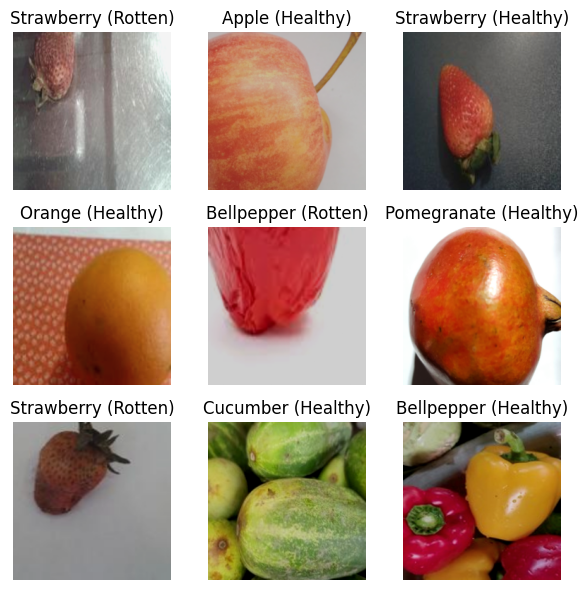

In [7]:
helper_utils.show_image_grid(train_loader, classes)

## Model Preparation

Training a deep network from scratch on a small dataset like this (~4,500 images) risks poor performance. A more practical approach for an end-to-end pipeline is to use a pre-trained model.

**ResNet18** provides a significant head start by leveraging powerful visual features already learned from millions of images, which saves time and improves results. ResNet18 is an ideal choice because it balances strong performance with a small, efficient architecture, making it a reliable and practical option for deployment.

* Initialize a [ResNet18](https://docs.pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html) model instance without any pre-trained weights (`weights=None`).
* Load the `state_dict` from a local `./pretrained_resnet18_weights/resnet18-f37072fd.pth` file containing the weights from a model pre-trained on ImageNet.
* Apply these pre-trained weights to the ResNet18 model instance.

In [8]:
# Load a pre-trained ResNet18 model architecture
resnet18_model = tv_models.resnet18(weights=None)

# Path to the local pre-trained weights file
weights_path = './pretrained_resnet18_weights/resnet18-f37072fd.pth'
# Load the weights from the file
state_dict = torch.load(weights_path)

# Apply the loaded weights to the model instance
resnet18_model.load_state_dict(state_dict)

<All keys matched successfully>

* Adapt the final layer of the model to match the number of classes in your specific dataset.
    * The `adapt_model_for_transfer_learning` function is:
        * Freezing the pre-trained layers.
        * Replacing the classifier head with a new one that is customized to output predictions for the specific number of classes.

In [9]:
# Get the total number of classes of the dataset
num_classes = len(classes)

# Adapt the model for transfer learning with the new number of classes
model = helper_utils.adapt_model_for_transfer_learning(resnet18_model, num_classes)

## Model Training

* Set the number of training epochs.
    * Running for 1 epoch should get you a validation accuracy of `>75%`
    * Feel free to set a different number of epochs

In [10]:
num_epochs = 1

* Run the training loop to fine-tune the model on the dataset.
* The output is a fully trained model ready for optimization.

In [11]:
trained_model = helper_utils.training_loop(model, train_loader, val_loader, num_epochs, DEVICE)

--- Starting Training ---


Epoch 1/1 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 1/1 [Val]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 1/1 Summary | Train Loss: 2.0163 | Val Loss: 0.9418 | Accuracy: 78.30%

--- Finished Training ---


## Model Conversion: PyTorch to ONNX

Now that you have a trained PyTorch model, the next practical step is to prepare it for deployment. To solve the challenge of cross-platform compatibility, you will convert your model to the ONNX format. You will achieve this conversion using the [torch.onnx](https://docs.pytorch.org/docs/stable/onnx.html) module, specifically by calling its `export()` function to capture the model's design and weights into a portable `.onnx` file.

* Set the model to evaluation mode (`model.eval()`) before export.
* Create a dummy input tensor with the shape the model expects (`1, 3, 224, 224` in this case), which is necessary for the exporter to trace the model's architecture.
* Call the [torch.onnx.export](https://docs.pytorch.org/docs/stable/onnx.html#module-torch.onnx) function with several key parameters:
    * The trained PyTorch model is the first argument.
    * The `export_params=True` argument ensures that the model's trained weights are stored in the ONNX file.
    * `opset_version` is set to specify the ONNX version to use.
    * `do_constant_folding=True` is an optimization that pre-computes constant values in the graph.
    * `input_names` and `output_names` assign explicit names to the model's input and output tensors, which makes them easier to identify and use later.
    * `dynamic_axes` specifies that the first dimension (the batch size) can vary in size during inference, allowing for flexible batch processing.

In [12]:
# Set the model to evaluation mode (important first step)
model.eval()

print("Exporting model to ONNX...")

# Create a dummy input tensor with the expected shape
dummy_input = torch.randn(1, 3, 224, 224, device=DEVICE)

# Export the model to the ONNX format
torch.onnx.export(
    trained_model,                # The trained PyTorch model to be exported. 
    dummy_input,                  # A dummy input tensor with the expected shape for tracing. 
    "fruit_veg_model.onnx",       # The name of the output .onnx file. 
    export_params=True,           # Exports the model's trained weights (parameters). 
    opset_version=11,             # The ONNX version to use. Using 11 to be compatible with TF in the Optional section
    do_constant_folding=True,     # An optimization that pre-computes constant expressions in the model. 
    input_names=['input'],        # Assigns a name to the model's input tensor for easier identification. 
    output_names=['output'],      # Assigns a name to the model's output tensor. 
    # Specifies which dimensions can vary in size, like the batch size. 
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}       
)

print("\nModel successfully exported as fruit_veg_model.onnx")

Exporting model to ONNX...

Model successfully exported as fruit_veg_model.onnx


## Running Inference with ONNX

* Load the exported `fruit_veg_model.onnx` model into an ONNX Runtime [InferenceSession](https://onnxruntime.ai/docs/api/python/api_summary.html#onnxruntime.InferenceSession).
* Retrieve the model's input name, which was assigned during the export step.

In [13]:
# Load the ONNX model into an ONNX Runtime inference session
ort_session = ort.InferenceSession("fruit_veg_model.onnx")

# Get the name of the model's input layer
input_name = ort_session.get_inputs()[0].name

* Prepare a batch of validation images, ensuring the data is in the tensor shape the model expects.

In [14]:
# Get a batch of validation data to run predictions on
val_iter = iter(val_loader)
images, labels = next(val_iter)

# Use the first 9 images of the batch for prediction
input_data = images[:9].cpu().numpy()
# Get the corresponding true labels
true_labels = labels[:9].numpy()

* Call [session.run()](https://onnxruntime.ai/docs/api/python/api_summary.html#onnxruntime.InferenceSession.run) to perform inference.
    * Passing `None` for the output names tells the runtime to return all model outputs.
    * The input data is passed as a dictionary where the key is the input name and the value is the image tensor.
    * For a model with a single output, the predictions are contained in the first element of the returned list.

Displaying predictions from the ONNX model...



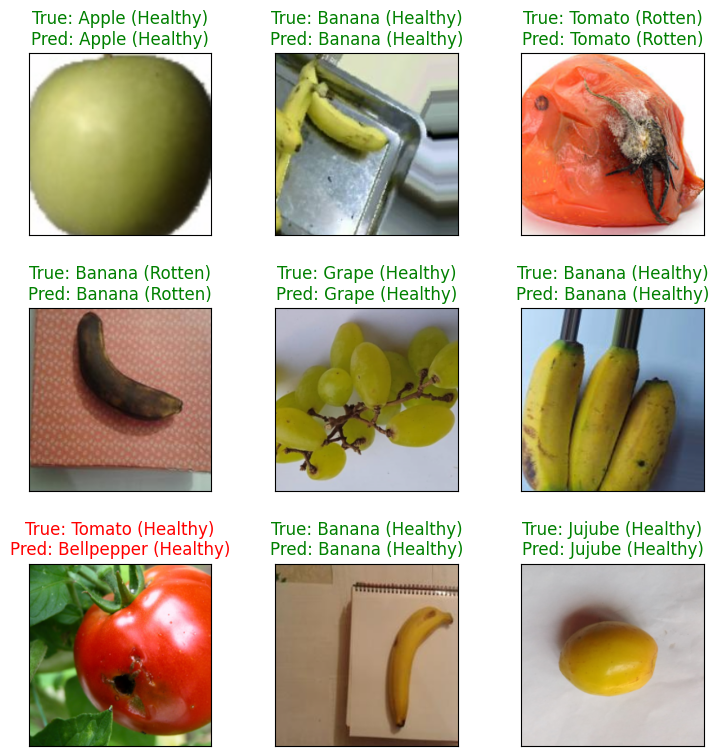

In [15]:
# Run inference using the ONNX Runtime session
ort_outputs = ort_session.run(None, {input_name: input_data})
# Extract the predictions from the output
predictions = ort_outputs[0]

print("Displaying predictions from the ONNX model...\n")
# Visualize the predictions against the true labels
helper_utils.show_prediction_grid(input_data, true_labels, predictions, classes)

## (Optional) Convert ONNX Model to TensorFlow

This optional section demonstrates one of the biggest advantages of using the ONNX format: its portability. Once your model is in the ONNX format, you are no longer locked into the PyTorch ecosystem and can use it in other frameworks. You might do this to integrate your model into an existing TensorFlow-based application or deployment pipeline. This is achieved by loading the `.onnx` file and using the [onnx-tf](https://github.com/onnx/onnx-tensorflow) backend converter library to prepare a TensorFlow-compatible version of the model.

* First, load the `.onnx` model and prepare it by using the `onnx-tf` [backend](https://github.com/onnx/onnx-tensorflow/blob/main/onnx_tf/backend.py).
    * This creates an in-memory TensorFlow representation (`tf_rep`), which acts as a bridge for the next step.

In [16]:
# Load the ONNX model from the file
print("Loading ONNX model and creating TF representation...")

onnx_model = onnx.load("fruit_veg_model.onnx")
# Prepare the TensorFlow representation of the ONNX model
tf_rep = prepare(onnx_model)

# Print a success message
print("In-memory TensorFlow representation created.")

Loading ONNX model and creating TF representation...
In-memory TensorFlow representation created.


* Now, export this in-memory representation to TensorFlow's standard `SavedModel` format.
    * This saves the model as a standalone, native TensorFlow artifact.
 
**Note**: The following execution may generate some warnings, which can be safely **ignored**. A successful export is indicated by the `Export complete.` message at the end of the output.

In [17]:
# Define a path and export the graph
tf_model_path = "./fruit_veg_tf_savedmodel"

print(f"Exporting native TensorFlow model to: {tf_model_path}")

try:
    # Attempt to export the graph
    tf_rep.export_graph(tf_model_path)
    
    # This success message will only be printed if the line above runs without errors
    print("\nExport complete.")

except Exception as e:
    # This message will be printed if any error occurs during the export process
    print(f"\nAn error occurred during export: {e}")

Exporting native TensorFlow model to: ./fruit_veg_tf_savedmodel


INFO:absl:Function `__call__` contains input name(s) x, y with unsupported characters which will be renamed to transpose_62_x, add_20_y in the SavedModel.
INFO:absl:Found untraced functions such as gen_tensor_dict while saving (showing 1 of 1). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ./fruit_veg_tf_savedmodel/assets


INFO:tensorflow:Assets written to: ./fruit_veg_tf_savedmodel/assets
INFO:absl:Writing fingerprint to ./fruit_veg_tf_savedmodel/fingerprint.pb



Export complete.


* Prepare a batch of validation data for prediction and visualization.

In [18]:
# Get a fresh batch of validation images and labels
val_iter = iter(val_loader)
images, labels = next(val_iter)

# Prepare the first 9 images and their labels for the prediction grid
input_data = images[:9].cpu().numpy()
true_labels = labels[:9].numpy()

* Load the native TensorFlow model from the path where you previously saved it.
    * This uses the standard `tf.saved_model.load()` function and retrieves the specific inference function from the model's signature.

In [19]:
# NATIVE TENSORFLOW SYNTAX: Load the model from the SavedModel format
print(f"Loading native TensorFlow model from: {tf_model_path}")
loaded_tf_model = tf.saved_model.load(tf_model_path)

# NATIVE TENSORFLOW SYNTAX: Get the specific function for serving/inference
inference_func = loaded_tf_model.signatures["serving_default"]

print("Model loaded successfully.")

Loading native TensorFlow model from: ./fruit_veg_tf_savedmodel
Model loaded successfully.


* Finally, run inference using the loaded TensorFlow model.
    * This involves converting your NumPy image data into a TensorFlow tensor, calling the model's inference function, and converting the resulting predictions back to a NumPy array for easy use.
* Visualize the model's predictions against the true labels.

Displaying predictions from the NATIVE TensorFlow model...



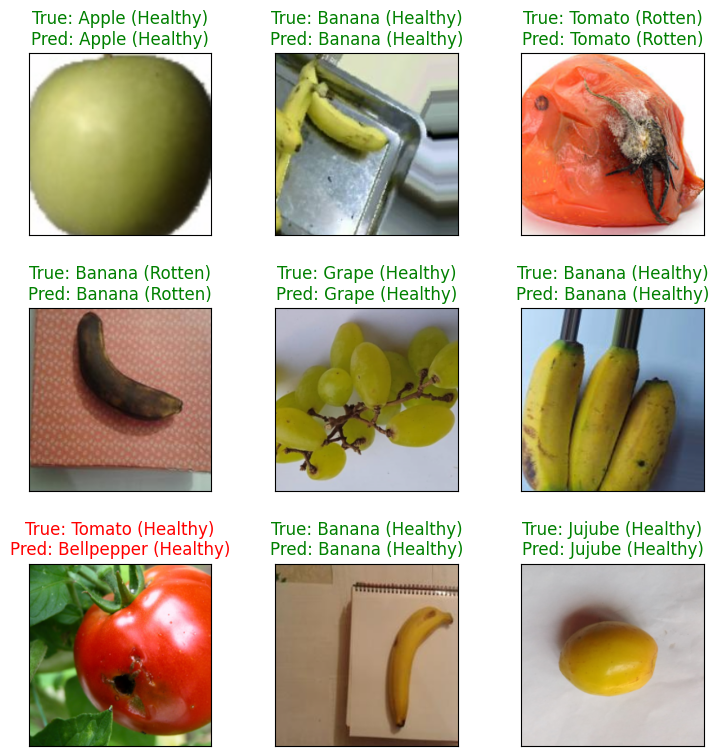

In [20]:
# NATIVE TENSORFLOW SYNTAX: Convert the input data to a TensorFlow tensor
input_tensor = tf.convert_to_tensor(input_data, dtype=tf.float32)

# NATIVE TENSORFLOW SYNTAX: Run prediction using the loaded function
predictions_dict = inference_func(input=input_tensor)

# NATIVE TENSORFLOW SYNTAX: Extract the output tensor and convert to a NumPy array
tf_predictions_np = predictions_dict['output'].numpy()

# Visualize the results
print("Displaying predictions from the NATIVE TensorFlow model...\n")
helper_utils.show_prediction_grid(input_data, true_labels, tf_predictions_np, classes)

## Conclusion

Congratulations on successfully converting a PyTorch model to the ONNX format and running inference with it!

By completing this process, you have seen firsthand how to decouple your model from its original training framework. Your model is no longer just a PyTorch artifact; it is now in a standardized format that can be deployed across a multitude of environments that support the ONNX standard. As another practical example, the optional section of this notebook showed you how to take this portability a step further by converting the ONNX model into a TensorFlow representation and running inference with it.


This is a key step in preparing your models, making them more versatile and efficient for production environments. You are now equipped with a vital skill for bridging the gap between model development and real-world deployment.